# Predict

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")
import string
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from rmgpy.data.thermo import ThermoDatabase, ThermoGroups

from tree.thermo import ThermoGroups as SIDTThermoGroups
from tree.utils import make_mol
from tree.parameters import Ts

# Load data

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

# Make mols

In [3]:
mols = hbi_unc_df["resonance_radical_smiles"].apply(make_mol)
mols = mols.to_list()

# Load thermo database

In [4]:
def make_prediction(thermo_database, tree, mol):
    atoms = {"*": atom for atom in mol.atoms if atom.radical_electrons==1}
    return thermo_database._add_group_thermo_data(None, tree, mol, atoms)[0]

In [5]:
thermo_database = ThermoDatabase()

# Predict with empirical tree

In [6]:
empirical_tree = ThermoGroups().load("/home/gridsan/hwpang/Software/RMG-database/input/thermo/groups/radical.py", thermo_database.local_context, thermo_database.global_context)

In [7]:
thermos = [make_prediction(thermo_database, empirical_tree, mol) for mol in mols]

In [8]:
hbi_pred_emp_df = hbi_unc_df[["resonance_radical_smiles"]]
hbi_pred_emp_df["HBI_H298 (kcal/mol)"] = [thermo.H298.value_si/4184 for thermo in thermos]
hbi_pred_emp_df["unc_HBI_H298 (kcal/mol)"] = [thermo.H298.uncertainty_si/4184 for thermo in thermos]
hbi_pred_emp_df["HBI_Sint298 (cal/mol/K)"] = [thermo.S298.value_si/4.184 for thermo in thermos]
hbi_pred_emp_df["unc_HBI_Sint298 (cal/mol/K)"] = [thermo.S298.uncertainty_si/4.184 for thermo in thermos]
for i, T in enumerate(Ts):
    hbi_pred_emp_df[f"HBI_Cp{T} (cal/mol/K)"] = [thermo.Cpdata.value_si[i]/4.184 for thermo in thermos]
    hbi_pred_emp_df[f"unc_HBI_Cp{T} (cal/mol/K)"] = [thermo.Cpdata.uncertainty_si[i]/4.184 for thermo in thermos]
hbi_pred_emp_df["comment"] = [thermo.comment for thermo in thermos]

/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/ipykernel_launcher.

In [9]:
hbi_pred_emp_df.to_csv("../data/hbi_prediction_empirical.csv", index=False)

# Plot

In [10]:
hbi_pred_emp_df = pd.read_csv("../data/hbi_prediction_empirical.csv")

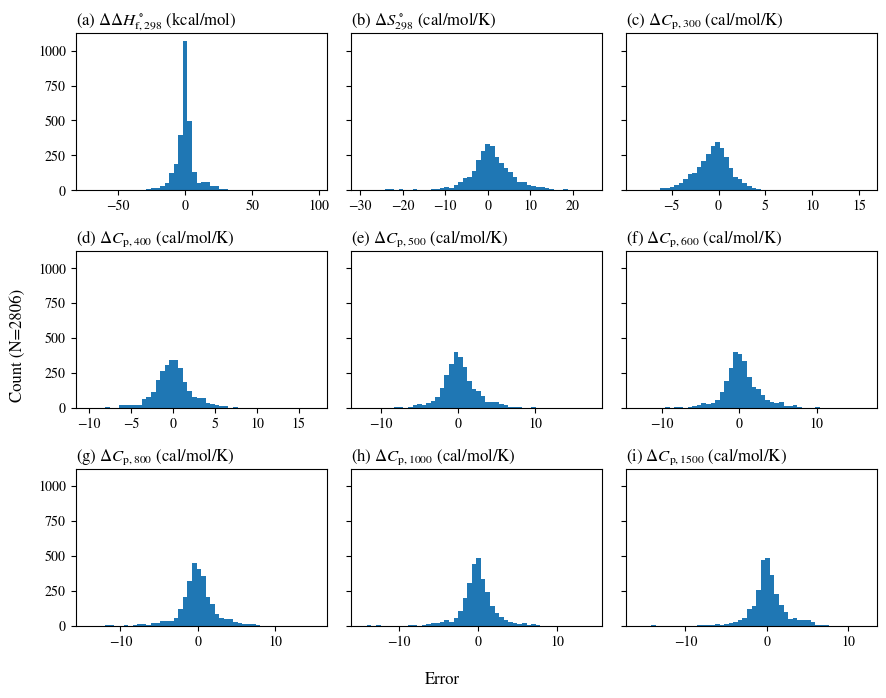

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
empirical_errors = hbi_pred_emp_df["HBI_H298 (kcal/mol)"] - hbi_unc_df["HBI_H298 (kcal/mol)"]
ax.hist(empirical_errors, bins=50)
ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
empirical_errors = hbi_pred_emp_df["HBI_Sint298 (cal/mol/K)"] - hbi_unc_df["HBI_Sint298 (cal/mol/K)"]
ax.hist(empirical_errors, bins=50)
ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    empirical_errors = hbi_pred_emp_df[f"HBI_Cp{T} (cal/mol/K)"] - hbi_unc_df[f"HBI_Cp{T} (cal/mol/K)"]
    ax.hist(empirical_errors, bins=50)
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

fig.supylabel(f"Count (N={len(hbi_unc_df.index)})")
fig.supxlabel(f"Error")

fig.tight_layout()
fig.savefig("../figures/hbi_prediction_empirical_error_hist.pdf", bbox_inches="tight")

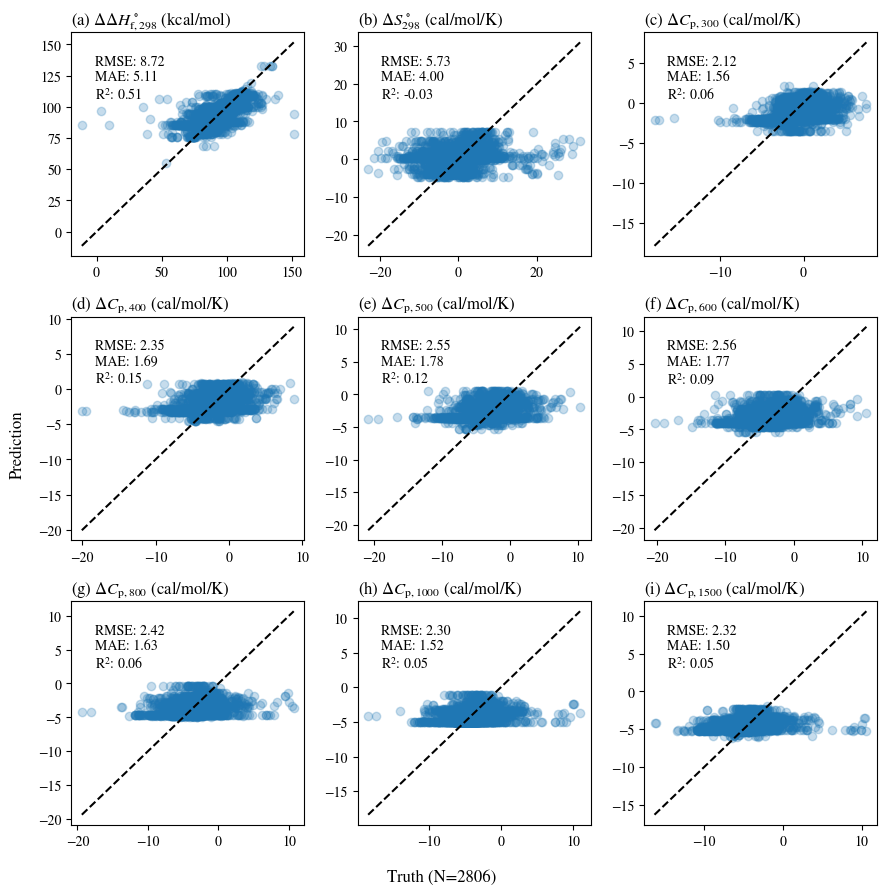

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ax = axs.flat[0]
true_ys = hbi_unc_df["HBI_H298 (kcal/mol)"]
pred_ys = hbi_pred_emp_df["HBI_H298 (kcal/mol)"]
min_y = min(true_ys.min(), pred_ys.min())
max_y = max(true_ys.max(), pred_ys.max())
rmse = np.sqrt(mean_squared_error(true_ys, pred_ys))
mae = mean_absolute_error(true_ys, pred_ys)
r2 = r2_score(true_ys, pred_ys)
ax.scatter(true_ys, pred_ys, alpha=0.25)
ax.plot([min_y, max_y], [min_y, max_y], "k--")
ax.text(0.1, 0.9, f"""RMSE: {rmse:.2f}
MAE: {mae:.2f}
R$^2$: {r2:.2f}""", ha="left", va="top", transform=ax.transAxes)
ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
true_ys = hbi_unc_df["HBI_Sint298 (cal/mol/K)"]
pred_ys = hbi_pred_emp_df["HBI_Sint298 (cal/mol/K)"]
min_y = min(true_ys.min(), pred_ys.min())
max_y = max(true_ys.max(), pred_ys.max())
rmse = np.sqrt(mean_squared_error(true_ys, pred_ys))
mae = mean_absolute_error(true_ys, pred_ys)
r2 = r2_score(true_ys, pred_ys)
ax.scatter(true_ys, pred_ys, alpha=0.25)
ax.plot([min_y, max_y], [min_y, max_y], "k--")
ax.text(0.1, 0.9, f"""RMSE: {rmse:.2f}
MAE: {mae:.2f}
R$^2$: {r2:.2f}""", ha="left", va="top", transform=ax.transAxes)
ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    true_ys = hbi_unc_df[f"HBI_Cp{T} (cal/mol/K)"]
    pred_ys = hbi_pred_emp_df[f"HBI_Cp{T} (cal/mol/K)"]
    min_y = min(true_ys.min(), pred_ys.min())
    max_y = max(true_ys.max(), pred_ys.max())
    rmse = np.sqrt(mean_squared_error(true_ys, pred_ys))
    mae = mean_absolute_error(true_ys, pred_ys)
    r2 = r2_score(true_ys, pred_ys)
    ax.scatter(true_ys, pred_ys, alpha=0.25)
    ax.plot([min_y, max_y], [min_y, max_y], "k--")
    ax.text(0.1, 0.9, f"""RMSE: {rmse:.2f}
MAE: {mae:.2f}
R$^2$: {r2:.2f}""", ha="left", va="top", transform=ax.transAxes)
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

fig.supylabel(f"Prediction")
fig.supxlabel(f"Truth (N={len(true_ys)})")

fig.tight_layout()
fig.savefig("../figures/hbi_prediction_empirical_parity.pdf", bbox_inches="tight")